Based on the following links to create this notebook:

https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy#scrollTo=bhsj7BTPHepg

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy


To run Gym, you have to install prerequisites like xvbf,opengl & other python-dev packages using the following codes.

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [1]:
!pip install gym  torch
!apt-get install python-opengl ffmpeg -y 
!apt install xvfb -y 
!pip install pyvirtualdisplay  
!pip install piglet 
!pip install gym[box2d] 
!pip install tensorflow 


Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


In [3]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [4]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
# import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
from collections import namedtuple
from itertools import count


In [5]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

def make_noise():
    mu, sigma = 0, 0.05 # mean and standard deviation
    return np.random.normal(mu, sigma, 1)[0]


# My Code

In [6]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class defaultActions:
    def __init__(self):

        self.main = [[0 , "Main off"],
                     [0.5 ,"Main slow"],
                     [0.75 , "Main meduim"],
                     [1    , "Main strong"]
                    ]
        self.left_right = [
                        [0, "Left Right off"],
                        [-0.5 , "Left slow"],
                        [-0.75  , "Left meduim"],
                        [-1 , "Left strong"],
                        
                        [0.5 , "Right slow"],
                        [0.75  , "Right meduim"],
                        [1 , "Right strong"],
                        ]
        self.all_actions = {}
        i = 0  
        for main_eng in self.main:
            for sec_eng in self.left_right:
#                 print (f"a{i},act:[{main_eng[0]},{sec_eng[0]},{main_eng[1]} {sec_eng[1]}]")
                self.all_actions[i] = [[main_eng[0],sec_eng[0]] , f"{main_eng[1]}, {sec_eng[1]}"]
                i+=1
        
    def get_full_action(self,id):
        return self.all_actions[id]

    def get_action(self,id,add_noise=True):
        if add_noise :
            return [self.all_actions[id][0][0]+make_noise(), self.all_actions[id][0][1]+make_noise()]
        else:
            return self.all_actions[id][0]

    def get_description(self,id):
        return self.all_actions[id][1]
    def get_action_count(self):
        return len(self.all_actions)
actions = defaultActions()
actions.get_action_count()


28

In [8]:
class model(nn.Module):
    def __init__(self, layers, name=""):
        super(model, self).__init__()
        self.name = ""
        self.layers = layers
        self.features = nn.Sequential(*layers)


    def name(self):
        return self.name

    def model_summery(self):
        return self.features.summary()

    def forward(self, x):
        return self.features(x)

In [9]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [10]:
TARGET_UPDATE = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
input_size = 8
h1 = 500
h2 = 500 
h3 = 500 
h4 = 500
h5 = 500
output_size = actions.get_action_count()
layers = [nn.Linear(input_size,h1) ,nn.ReLU(inplace=True), #, nn.BatchNorm1d(h1)
         nn.Linear(h1,h2) ,nn.ReLU(inplace=True),
         nn.Linear(h2,h3) ,nn.ReLU(inplace=True),
         nn.Linear(h3,h4) , nn.ReLU(inplace=True),
         nn.Linear(h4,h5) ,nn.ReLU(inplace=True),
         nn.Linear(h5,output_size),nn.ReLU(inplace=True) # , nn.BatchNorm1d(output_size)
         ]


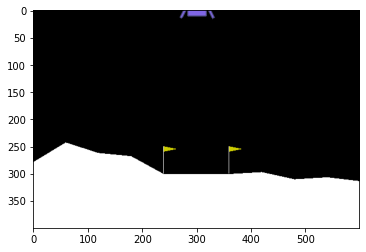

In [12]:
# Box2d Environment
env = gym.make('LunarLanderContinuous-v2')
env.reset()
plt.imshow(env.render('rgb_array'))


In [13]:
state_size = env.observation_space
print("state size is:", state_size)
a = env.action_space
print("action size=",a) 
state = env.reset()
print(state)   

state size is: Box(-inf, inf, (8,), float32)
action size= Box(-1.0, 1.0, (2,), float32)
[-1.3311387e-03  1.4140332e+00 -1.3484649e-01  1.3835415e-01
  1.5492757e-03  3.0544778e-02  0.0000000e+00  0.0000000e+00]


# Action Space
            #is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)

In [14]:
df = 0.9 #discount_factor
not_val = -999999
last_val = not_val
last_out = None
max_iterations = 3000
BATCH_SIZE = 128
torch.autograd.set_detect_anomaly(True)
#mytestmodel.zero_grad()


In [15]:
policy_net =  model(layers).to(device)
target_net =  model(layers).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.SGD(policy_net.parameters(), lr=0.35, momentum=0.9)


In [16]:
for a in range(5):
    memory = ReplayMemory(10000)
    env = gym.make('LunarLanderContinuous-v2')
    env.reset()
    env = wrap_env(env)
    done = False
    iter = 0
    print(done)
    observation = state = env.reset()

    action = 1
    TotalReward = 0

    while not done and iter < max_iterations :
      iter +=1
      optimizer.zero_grad()
    #   action = env.action_space.sample()
      action =  random.choice(actions.all_actions)
      if len(memory) < BATCH_SIZE:
        state_values = policy_net.forward(torch.from_numpy(observation))
        action = actions.get_action(state_values.argmax().item())
        observation, reward, done, _ = env.step(action)
        next_state = observation
        print("action is:",actions.get_full_action(state_values.argmax().item()) ,"reward: ",reward)
        next_values = target_net.forward(torch.from_numpy(observation))
        memory.push(state, action, next_state, reward)
      else:
        print(f"iter {iter}")
        transitions = memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        print(f"yalla {batch.state}")
        print(f"yalla2 {batch.action}")
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        # state_values = policy_net(state_batch).gather(1, action_batch)
        observation, reward, done, _ = env.step(action_batch[0])
        state_values = policy_net.forward(torch.from_numpy(observation))
        print("action is:",actions.get_full_action(state_values.argmax().item()) ,"reward: ",reward)
        next_values = target_net.forward(torch.from_numpy(observation))

      # action = actions.get_action(state_values.argmax().item())
      # observation, reward, done, _ = env.step(action)
      # print("action is:",actions.get_full_action(state_values.argmax().item()) ,"reward: ",reward)
      # next_values = target_net.forward(torch.from_numpy(observation))
      # memory.push(state, action, observation, reward)

      loss = F.smooth_l1_loss(state_values,torch.tensor([reward +df*next_values.max().item()], dtype=torch.float).unsqueeze(0) ) # Huber .unsqueeze(0)

      loss.backward()
      optimizer.step()


      TotalReward+= reward
      #print("state is:", observation)

      #if you want to see results on real-time 'open' the following 4 lines
    #   screen = env.render(mode='rgb_array')
    #   plt.imshow(screen)
    #   ipythondisplay.clear_output(wait=True)
    #   ipythondisplay.display(plt.gcf())


      if iter % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
    print(TotalReward,iter)

False
action is: [[1, 1], 'Main strong, Right strong'] reward:  4.106969886156618
action is: [[1, 1], 'Main strong, Right strong'] reward:  2.9907442664915096
action is: [[1, 1], 'Main strong, Right strong'] reward:  2.5328481449116613
action is: [[1, 1], 'Main strong, Right strong'] reward:  1.826527344656538


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


action is: [[1, 1], 'Main strong, Right strong'] reward:  1.4868487406092992
action is: [[1, 1], 'Main strong, Right strong'] reward:  1.275782269973805
action is: [[1, 1], 'Main strong, Right strong'] reward:  -0.18965857397970923
action is: [[1, 1], 'Main strong, Right strong'] reward:  -1.8695400855390734
action is: [[0.5, -0.5], 'Main slow, Left slow'] reward:  0.23313115895777287
action is: [[0.5, -0.5], 'Main slow, Left slow'] reward:  -1.3259143238549427
action is: [[0.5, -0.5], 'Main slow, Left slow'] reward:  0.7028219886657655
action is: [[0, 0.5], 'Main off, Right slow'] reward:  -3.049613954171008
action is: [[0, 0.5], 'Main off, Right slow'] reward:  -3.400579932906993
action is: [[0, 0.5], 'Main off, Right slow'] reward:  -3.091335658131186
action is: [[0.5, -1], 'Main slow, Left strong'] reward:  -1.1121348653141
action is: [[0.5, -1], 'Main slow, Left strong'] reward:  0.1455535265169499
action is: [[0.5, -1], 'Main slow, Left strong'] reward:  -0.03764581453183835
acti

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.071790256793315
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.0535034589609835
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.10214474820810437
action is: [[0, 0], 'Main off, Left Right off'] reward:  -2.5037704818867725
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.12332873727422111
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.542965263921974
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.1582528696712302
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.5184693675062817
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.19125315877738558
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.21918150041597073
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.6972063160745734
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.7202957807096994
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.33521929752947

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


action is: [[0, 0], 'Main off, Left Right off'] reward:  -2.259062845982669
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.4715047682573583
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.7409066907419174
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.7184783927742387
action is: [[0, 0], 'Main off, Left Right off'] reward:  -2.0580720485353083
action is: [[0, 0], 'Main off, Left Right off'] reward:  -2.007324566114562
action is: [[0, 0], 'Main off, Left Right off'] reward:  -2.0029788284245456
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.966708317455209
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.9655901515857351
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.5026874416036151
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.955585153206954
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.13264493301608127
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.8986209683123718
acti

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


action is: [[0, 0], 'Main off, Left Right off'] reward:  -2.33566783282032
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.9137344130707787
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.2593607696505842
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.7190631829344567
action is: [[0, 0], 'Main off, Left Right off'] reward:  -2.6446664980850585
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.3188695070176095
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.31451871597761283
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.33352614065964303
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.751658228468267
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.34853210860967465
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.37531650923307325
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.4731982014494918
action is: [[0, 0], 'Main off, Left Right off'] reward:  -2.65543171261628


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.681973521530216
action is: [[0, 0], 'Main off, Left Right off'] reward:  1.5444272921705817
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.8825378364531673
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.829023845573687
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.7752743526209258
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.7205084678816434
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.6649502861182555
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.608717817312396
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.5520515190189599
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.4949398439650565
action is: [[0, 0], 'Main off, Left Right off'] reward:  1.2445818116164218
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.4650403095921547
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.11521930115264353
act

In [17]:
env.close()
show_video()

In [18]:
print(iter)

73


In [19]:
#Draw random samples from a normal (Gaussian) distribution.
mu, sigma = 0, 0.05 # mean and standard deviation
s = np.random.normal(mu, sigma, 1)
print(s)

[-0.03189281]
